# Statistiken zur Entscheidungsfindung im Random Forest
Nach dem Training eines Random Forest Klassifikators können wir dessen interne Mechanismen untersuchen. APOC ermöglicht es, die Anzahl der Entscheidungen im Wald basierend auf den gegebenen Merkmalen abzurufen.

Siehe auch
* [Merkmalswichtigkeit](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
* [Verständnis der Merkmalswichtigkeit und wie man sie in Python implementiert (Towards Data Science)](https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285)

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import pandas as pd
import numpy as np
import apoc
import matplotlib.pyplot as plt
import pandas as pd

cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

Zu Demonstrationszwecken verwenden wir ein Bild von David Legland, das unter [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) im Repository [mathematical_morphology_with_MorphoLibJ](https://github.com/dlegland/mathematical_morphology_with_MorphoLibJ/blob/master/sampleImages/maize_clsm.tif) verfügbar ist. 

Wir fügen auch ein Labelbild hinzu, das in einem früheren Kapitel generiert wurde.

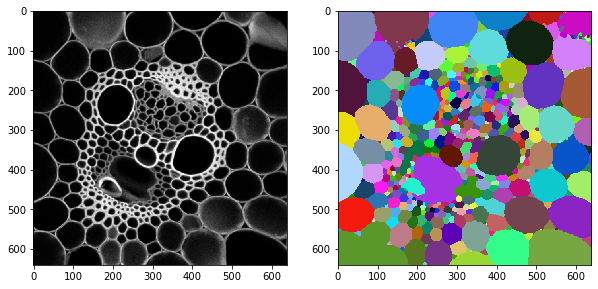

In [2]:
image = cle.push(imread('../../data/maize_clsm.tif'))
labels = cle.push(imread('../../data/maize_clsm_labels.tif'))

fix, axs = plt.subplots(1,2, figsize=(10,10))
cle.imshow(image, plot=axs[0])
cle.imshow(labels, plot=axs[1], labels=True)

Wir haben zuvor einen Objektklassifikator erstellt und wenden ihn jetzt auf das Paar von Intensitäts- und Labelbildern an.

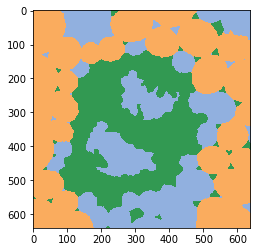

In [3]:
classifier = apoc.ObjectClassifier("../../data/maize_cslm_object_classifier.cl")
classification_map = classifier.predict(labels=labels, image=image)

cle.imshow(classification_map, labels=True, min_display_intensity=0)

## Klassifikatorstatistiken
Der geladene Klassifikator kann uns statistische Informationen über seine innere Struktur liefern. Der Random Forest Klassifikator besteht aus vielen Entscheidungsbäumen, und jeder Entscheidungsbaum besteht aus binären Entscheidungen auf mehreren Ebenen. Ein Wald mit 10 Bäumen trifft beispielsweise 10 Entscheidungen auf der ersten Ebene, da jeder Baum mindestens diese eine Entscheidung trifft. Auf der zweiten Ebene kann jeder Baum bis zu 2 Entscheidungen treffen, was zu maximal 20 Entscheidungen auf dieser Ebene führt. Wir können nun visualisieren, wie viele Entscheidungen auf jeder Ebene spezifische Merkmale berücksichtigen. Die Statistiken werden als zwei Wörterbücher ausgegeben, die mit [pandas](https://pandas.pydata.org/) visualisiert werden können.

In [4]:
shares, counts = classifier.statistics()

Zunächst zeigen wir die Anzahl der Entscheidungen auf jeder Ebene. Wieder steigt die Gesamtzahl der Entscheidungen von niedrigeren zu höheren Ebenen, in dieser Tabelle von links nach rechts.

In [5]:
pd.DataFrame(counts).T

0   1
area                                        4  33
mean_intensity                             32  44
standard_deviation_intensity               37  44
touching_neighbor_count                     8  28
average_distance_of_n_nearest_neighbors=6  19  34

Die obige Tabelle zeigt uns, dass auf der ersten Ebene 26 Bäume `mean_intensity` berücksichtigt haben, was die höchste Zahl auf dieser Ebene ist. Auf der zweiten Ebene wurden 30 Entscheidungen getroffen, die die `standard_deviation_intensity` berücksichtigten. Der durchschnittliche Abstand der n-nächsten Nachbarn wurde 21-29 Mal auf dieser Ebene berücksichtigt, was nahe beieinander liegt. Man könnte argumentieren, dass Intensität und Schwerpunktabstände zwischen Nachbarn die entscheidenden Parameter für die Unterscheidung von Objekten waren.

Als Nächstes betrachten wir die normalisierten `shares`, die die Zählungen geteilt durch die Gesamtzahl der Entscheidungen pro Tiefenebene sind. Wir visualisieren dies farblich, um Merkmale mit hohen und niedrigen Werten hervorzuheben.

In [6]:
def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(shares).T
df.style.pipe(colorize)

Ergänzend zu unseren oben beschriebenen Erkenntnissen können wir hier auch sehen, dass die Verteilung der Entscheidungen auf den Ebenen gleichmäßiger wird, je höher die Ebene ist. Daher könnte man in Betracht ziehen, einen Klassifikator mit vielleicht nur zwei Tiefenebenen zu trainieren.

## Merkmalswichtigkeit
Ein gängigeres Konzept zur Untersuchung der Relevanz extrahierter Merkmale ist die [Merkmalswichtigkeit](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html), die aus den oben gezeigten Klassifikatorstatistiken berechnet wird und möglicherweise leichter zu interpretieren ist, da es sich um eine einzelne Zahl handelt, die jedes Merkmal beschreibt.

In [7]:
feature_importance = classifier.feature_importances()
feature_importance = {k:[v] for k, v in feature_importance.items()}
feature_importance

{'area': [0.1023460967511782],
 'mean_intensity': [0.27884719464885743],
 'standard_deviation_intensity': [0.34910187501327306],
 'touching_neighbor_count': [0.09231893555382481],
 'average_distance_of_n_nearest_neighbors=6': [0.1773858980328665]}

In [8]:
def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(feature_importance).T
df.style.pipe(colorize)